In [1227]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1228]:
data=pd.read_excel(r'D:\data_storage\Projects\flight_price_ml\data.xlsx')
data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [1229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [1230]:
#---------------------------
#Cleaning
#---------------------------

In [1231]:
data['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [1232]:
#Additional_Info doesn't provide much information, let's drop it
data.drop(columns=['Additional_Info'],inplace=True);

In [1233]:
sum=data.isnull().sum()
pd.DataFrame({'count':sum,'%':sum*100/data.shape[0]})

,count,%
Airline,0,0.000000
Date_of_Journey,0,0.000000
Source,0,0.000000
Destination,0,0.000000
Route,1,0.009361
Dep_Time,0,0.000000
Arrival_Time,0,0.000000
Duration,0,0.000000
Total_Stops,1,0.009361
Price,0,0.000000


In [1234]:
#clearing rows with nulls
data.dropna(inplace=True)

In [1235]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Price               int64
dtype: object

In [1236]:
#---------------------------
#Encoding
#---------------------------

In [1237]:
#encoding some categorical variables

#source-destination
data['Source-Destination']=data[['Source','Destination']].apply('-'.join,axis=1)
source_destination=pd.get_dummies(data['Source-Destination'])
source_destination=source_destination.rename({k:'Route_'+k for k in source_destination.columns},axis=1)
data=data.join(source_destination)
#airline
airlines=data.groupby(['Airline'])['Price'].mean().sort_values()
data['Airline_Encoded']=data['Airline'].map(airlines)

data.head(3)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Source-Destination,Route_Banglore-Delhi,Route_Banglore-New Delhi,Route_Chennai-Kolkata,Route_Delhi-Cochin,Route_Kolkata-Banglore,Route_Mumbai-Hyderabad,Airline_Encoded
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,3897,Banglore-New Delhi,0,1,0,0,0,0,5673.682903
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,7662,Kolkata-Banglore,0,0,0,0,1,0,9612.427756
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,13882,Delhi-Cochin,0,0,0,1,0,0,11643.923357


In [1238]:
#converting to datetime
for col in ['Date_of_Journey','Dep_Time','Arrival_Time']:
  data[col]=pd.to_datetime(data[col],dayfirst=True)

#converting time to decimal hours
for col in ['Dep_Time',"Arrival_Time"]:
  data[col+'_Hour']=data[col].dt.hour+data[col].dt.minute/60

#converting date to month and day of week
data['Date_of_Journey_Month']=data['Date_of_Journey'].dt.month
data['Date_of_Journey_Day_of_Week']=data['Date_of_Journey'].dt.day_of_week

data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Route_Banglore-New Delhi,Route_Chennai-Kolkata,Route_Delhi-Cochin,Route_Kolkata-Banglore,Route_Mumbai-Hyderabad,Airline_Encoded,Dep_Time_Hour,Arrival_Time_Hour,Date_of_Journey_Month,Date_of_Journey_Day_of_Week
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-02-20 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,3897,...,1,0,0,0,0,5673.682903,22.333333,1.166667,3,6
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2023-02-20 05:50:00,2023-02-20 13:15:00,7h 25m,2 stops,7662,...,0,0,0,1,0,9612.427756,5.833333,13.250000,5,2


In [1239]:
#parsing duration
def preprocess_duration(x):
  if 'h' not in x:
      x='0h '+x
  elif 'm' not in x:
      x=x+' 0m'
  return x

data['Duration']=data['Duration'].apply(preprocess_duration)

#data['Duration_Hour']=data['Duration'].apply(lambda x:int(x.split(' ')[0][0:-1]))
#data['Duration_minute']=data['Duration'].apply(lambda x:int(x.split(' ')[1][0:-1]))
def str_time_parser(x):
  a=x.split(' ')
  return(int(a[0][0:-1])+int(a[1][0:-1])/60)

data['Duration_Hour']=data['Duration'].apply(lambda x: str_time_parser(x))

data[['Duration','Duration_Hour']].head(2)



,Duration,Duration_Hour
0,2h 50m,2.833333
1,7h 25m,7.416667


In [1240]:
#counting number of stops
data['Stops_Count']=data['Route'].apply(lambda x: x.count('→')-1)

data[['Route','Stops_Count']].head(6)


,Route,Stops_Count
0,BLR → DEL,0
1,CCU → IXR → BBI → BLR,2
2,DEL → LKO → BOM → COK,2
3,CCU → NAG → BLR,1
4,BLR → NAG → DEL,1
5,CCU → BLR,0


In [1241]:

data['Stops_Count'].value_counts()

1    5625
0    3491
2    1520
3      45
4       1
Name: Stops_Count, dtype: int64

In [1242]:
#---------------------------
#Exploration
#---------------------------
data.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Route_Delhi-Cochin,Route_Kolkata-Banglore,Route_Mumbai-Hyderabad,Airline_Encoded,Dep_Time_Hour,Arrival_Time_Hour,Date_of_Journey_Month,Date_of_Journey_Day_of_Week,Duration_Hour,Stops_Count
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-02-20 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,3897,...,0,0,0,5673.682903,22.333333,1.166667,3,6,2.833333,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2023-02-20 05:50:00,2023-02-20 13:15:00,7h 25m,2 stops,7662,...,0,1,0,9612.427756,5.833333,13.250000,5,2,7.416667,2
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,2023-02-20 09:25:00,2023-06-10 04:25:00,19h 0m,2 stops,13882,...,1,0,0,11643.923357,9.416667,4.416667,6,6,19.000000,2


<Axes: xlabel='Airline', ylabel='Price'>

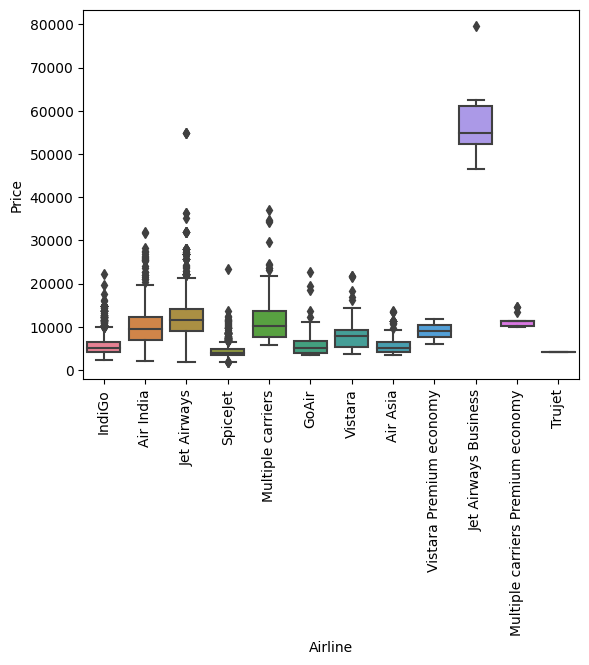

In [1243]:
#A look at the effect of airline on price
plot=sns.boxplot(data=data,x='Airline',y='Price',palette="husl")
plt.setp(plot.get_xticklabels(),rotation=90)
plot


<Axes: xlabel='Source-Destination', ylabel='Price'>

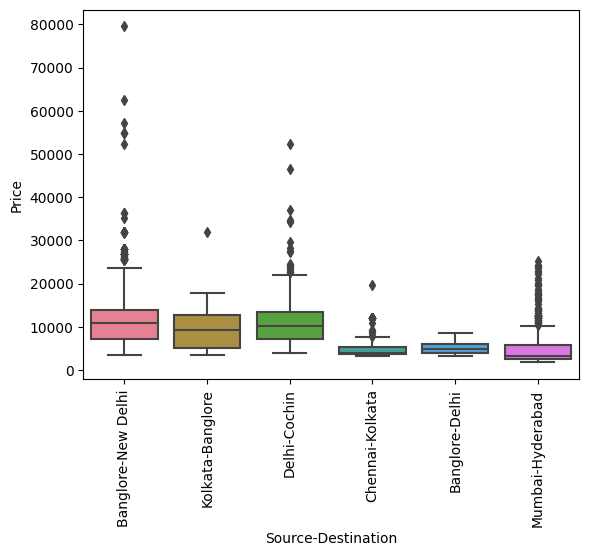

In [1244]:
#A look at the effect of the route on price
plot=sns.boxplot(data=data,x='Source-Destination',y='Price',palette="husl")
plt.setp(plot.get_xticklabels(),rotation=90)
plot

<Axes: xlabel='Stops_Count', ylabel='Price'>

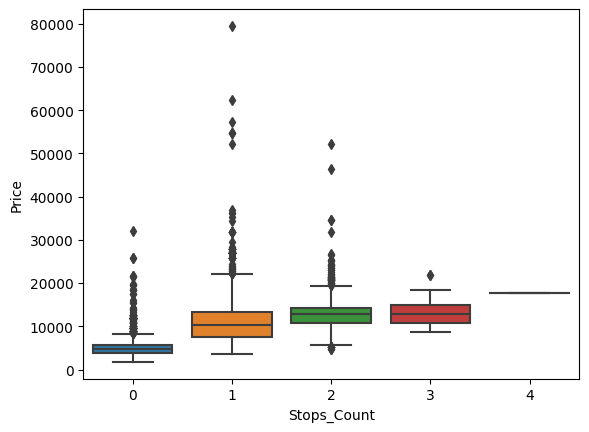

In [1245]:
#Look a the effect of the number of stops on price
plot=sns.boxplot(data=data,x='Stops_Count',y='Price')
plot

<Axes: xlabel='Source-Destination', ylabel='Price'>

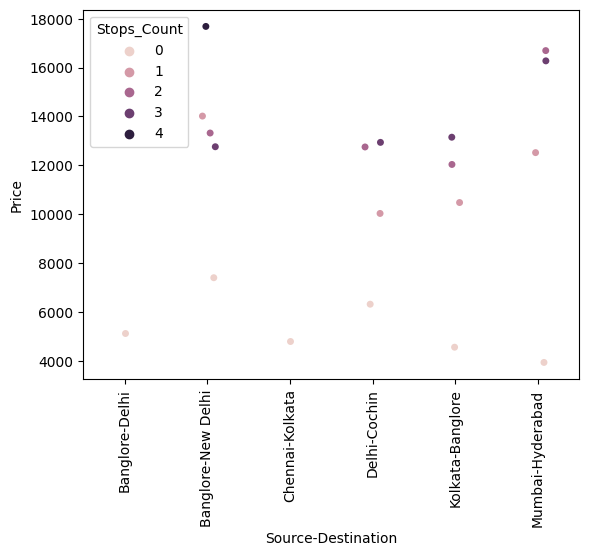

In [1246]:
#Perhaps the reason the price increases with the number of stops
#is becaused it is a longer route...Let's see
group=data[['Source-Destination','Stops_Count','Price']].groupby(['Source-Destination','Stops_Count']).mean()
plot=sns.stripplot(data=group,x='Source-Destination',y='Price',hue='Stops_Count')
plt.setp(plot.get_xticklabels(),rotation=90)
plot

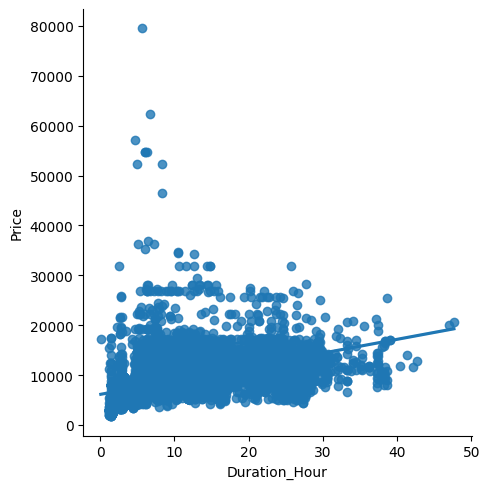

In [1247]:
#It seems more stops simply = more expensive
#Let's look at the impact of flight duration
plot=sns.lmplot(data=data,x='Duration_Hour',y='Price')
plot

In [1248]:
#Duration seemingly have no effect on price.
#It is probably highly collinear with number of stops
data['Stops_Count'].corr(data['Duration_Hour'])

0.7380709166001782

In [1249]:
# That's a pretty high correlation meaning this column is redundant
#Let's drop it then
data.drop(columns=['Duration','Duration_Hour'],inplace=True);

C:\Users\Danick Carrier\AppData\Local\Temp\ipykernel_12416\1015411857.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


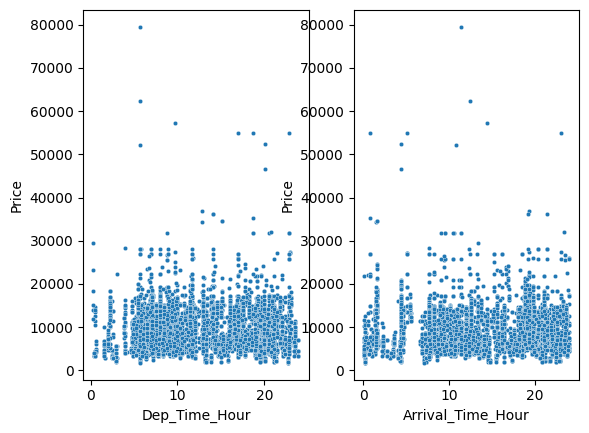

In [1250]:
#Let's look a the impact of the departure and arrival hour
fig,ax=plt.subplots(1,2)
sns.scatterplot(data=data,x='Dep_Time_Hour',y='Price',ax=ax[0],s=10)
sns.scatterplot(data=data,x='Arrival_Time_Hour',y='Price',ax=ax[1],s=10)
fig.show()

In [1251]:
#They both seem to have no effect on price, let's drop them
data.drop(columns=['Dep_Time','Arrival_Time','Dep_Time_Hour','Arrival_Time_Hour'],inplace=True);

<Axes: xlabel='Date_of_Journey_Month', ylabel='Price'>

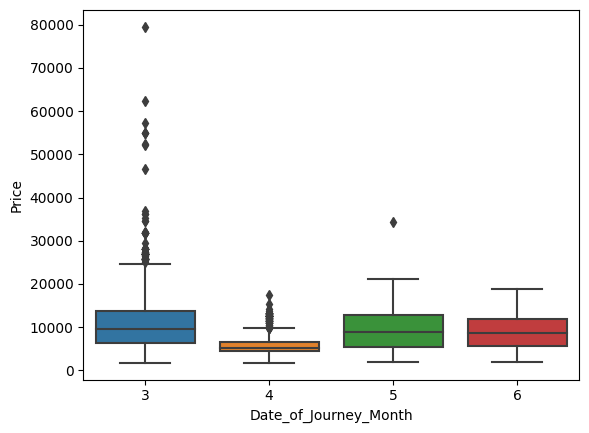

In [1252]:
#Let's look at the effect of the month
sns.boxplot(data=data,x='Date_of_Journey_Month',y='Price')


In [1253]:
#Seems to have an effect so let's one hot encode it
month=pd.get_dummies(data['Date_of_Journey_Month'])
month=month.rename({k:'Month_'+str(k) for k in month.columns},axis=1)
data=data.join(month)
data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Price,Source-Destination,Route_Banglore-Delhi,Route_Banglore-New Delhi,...,Route_Kolkata-Banglore,Route_Mumbai-Hyderabad,Airline_Encoded,Date_of_Journey_Month,Date_of_Journey_Day_of_Week,Stops_Count,Month_3,Month_4,Month_5,Month_6
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,non-stop,3897,Banglore-New Delhi,0,1,...,0,0,5673.682903,3,6,0,1,0,0,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,7662,Kolkata-Banglore,0,0,...,1,0,9612.427756,5,2,2,0,0,1,0


<Axes: xlabel='Date_of_Journey_Day_of_Week', ylabel='Price'>

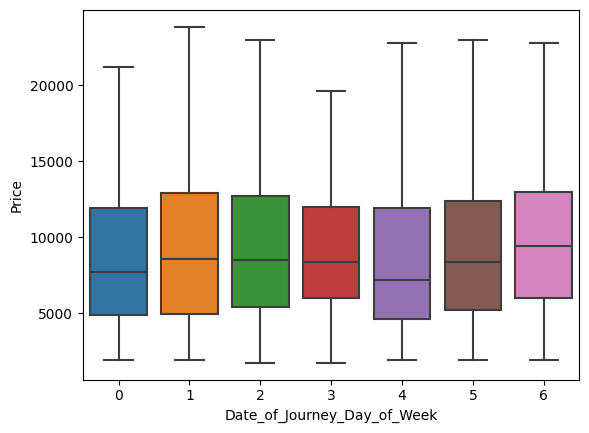

In [1254]:
#Let's see the effect of the day of the week
sns.boxplot(data=data,x='Date_of_Journey_Day_of_Week',y='Price',showfliers=False)


In [1255]:
#It does have an effect, let's one hot encode it
dayweek=pd.get_dummies(data['Date_of_Journey_Day_of_Week'])
dayweek=dayweek.rename({k:'Day_of_Week_'+str(k) for k in dayweek.columns},axis=1)
data=data.join(dayweek)
data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Price,Source-Destination,Route_Banglore-Delhi,Route_Banglore-New Delhi,...,Month_4,Month_5,Month_6,Day_of_Week_0,Day_of_Week_1,Day_of_Week_2,Day_of_Week_3,Day_of_Week_4,Day_of_Week_5,Day_of_Week_6
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,non-stop,3897,Banglore-New Delhi,0,1,...,0,0,0,0,0,0,0,0,0,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,7662,Kolkata-Banglore,0,0,...,0,1,0,0,0,1,0,0,0,0


In [1256]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Total_Stops', 'Price', 'Source-Destination', 'Route_Banglore-Delhi',
       'Route_Banglore-New Delhi', 'Route_Chennai-Kolkata',
       'Route_Delhi-Cochin', 'Route_Kolkata-Banglore',
       'Route_Mumbai-Hyderabad', 'Airline_Encoded', 'Date_of_Journey_Month',
       'Date_of_Journey_Day_of_Week', 'Stops_Count', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Day_of_Week_0', 'Day_of_Week_1', 'Day_of_Week_2',
       'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5', 'Day_of_Week_6'],
      dtype='object')

In [1258]:
train_data=data.select_dtypes([np.number])
train_data.drop(inplace=True,columns=['Date_of_Journey_Month','Date_of_Journey_Day_of_Week']);
train_data.columns


Index(['Price', 'Route_Banglore-Delhi', 'Route_Banglore-New Delhi',
       'Route_Chennai-Kolkata', 'Route_Delhi-Cochin', 'Route_Kolkata-Banglore',
       'Route_Mumbai-Hyderabad', 'Airline_Encoded', 'Stops_Count', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Day_of_Week_0', 'Day_of_Week_1',
       'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5',
       'Day_of_Week_6'],
      dtype='object')